<a href="https://colab.research.google.com/github/JuliaShutova/-/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1GHIUeCjB5nks1RRHwyDY0RI0Dg73QlpG
From (redirected): https://drive.google.com/uc?id=1GHIUeCjB5nks1RRHwyDY0RI0Dg73QlpG&confirm=t&uuid=31aa6a39-9813-45db-937c-6e1dc831ac9a
To: /content/data.parquet
100%|██████████| 1.37G/1.37G [00:08<00:00, 165MB/s]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ок
                   ts              ip  page_view_order_number  \
0 2024-10-01 07:05:07  185.169.154.88                       1   
1 2024-10-01 07:05:07  185.169.154.88                       1   
2 2024-10-01 07:05:07  185.169.154.88                       1   
3 2024-10-01 07:05:07   81.23.167.114                       1   
4 2024-10-01 07:05:07     62.32.76.90                       1   

   event_order_number        event  secs  \
0                   5    page_ping     0   
1                   4    page_ping     1   
2                   3  page_scroll     1   
3                   9    page_ping    25   
4                   7    page_ping     2   

                                            url  \
0                                                 
1                                                 
2  https://b4fd7a71f468fc04.ru/3bf34e24e44cd24d   
3       

<ipython-input-1-15c822d89756>:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data['time_bin'] = data['ts'].dt.floor('5S')


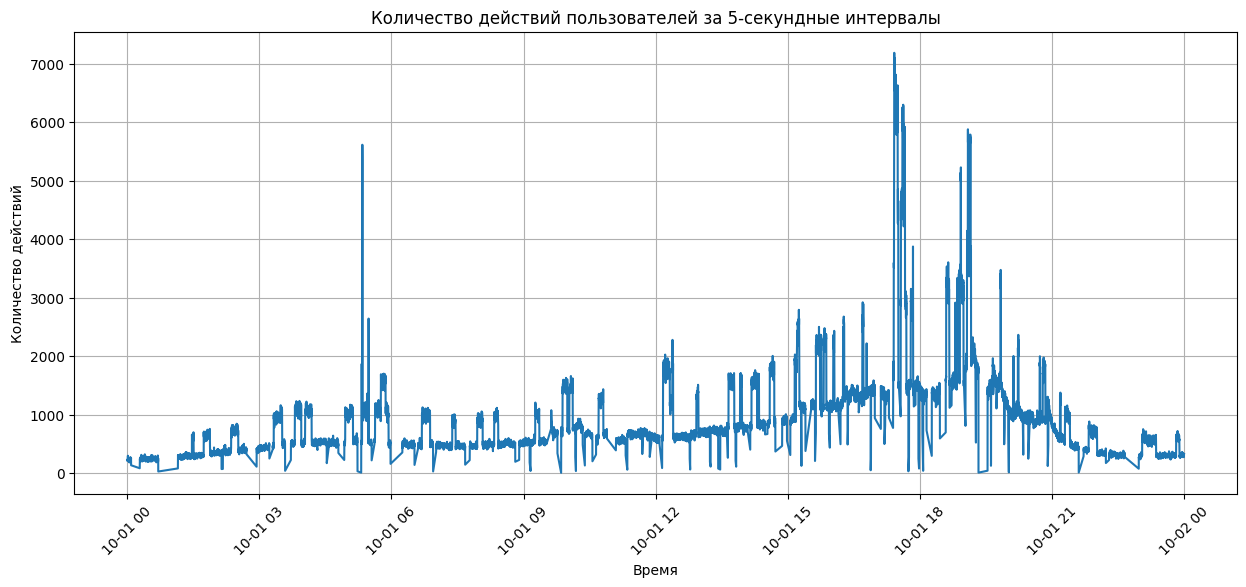

Порог аномальной активности: 3241.3 действий за 5 секунд
Найдено 290 аномальных интервалов:
                 time_bin  count
2837  2024-10-01 05:20:15   4859
2838  2024-10-01 05:20:20   5616
2839  2024-10-01 05:20:25   5524
2840  2024-10-01 05:20:30   5354
2841  2024-10-01 05:20:35   3640
...                   ...    ...
10838 2024-10-01 19:09:35   3828
11153 2024-10-01 19:49:55   3410
11155 2024-10-01 19:50:05   3476
11156 2024-10-01 19:50:10   3294
11157 2024-10-01 19:50:15   3324

[290 rows x 2 columns]

Топ пользователей в аномальных интервалах:
                                total_actions  unique_ip  device_types
randPAS_user_passport_id                                              
                                      1334122      67896             5
aGL3.;6:R2G<^8(1*j_8x)hL.*a"X0            256          1             2
F*Hb7E49iY EohSGgWy9/Oko&wxfjn            169          1             2
q-I/2v+6q(@ZApxb%u-6N?l2qERBUT            168          1             2
'Ost!ivbJ(%}f24=dk

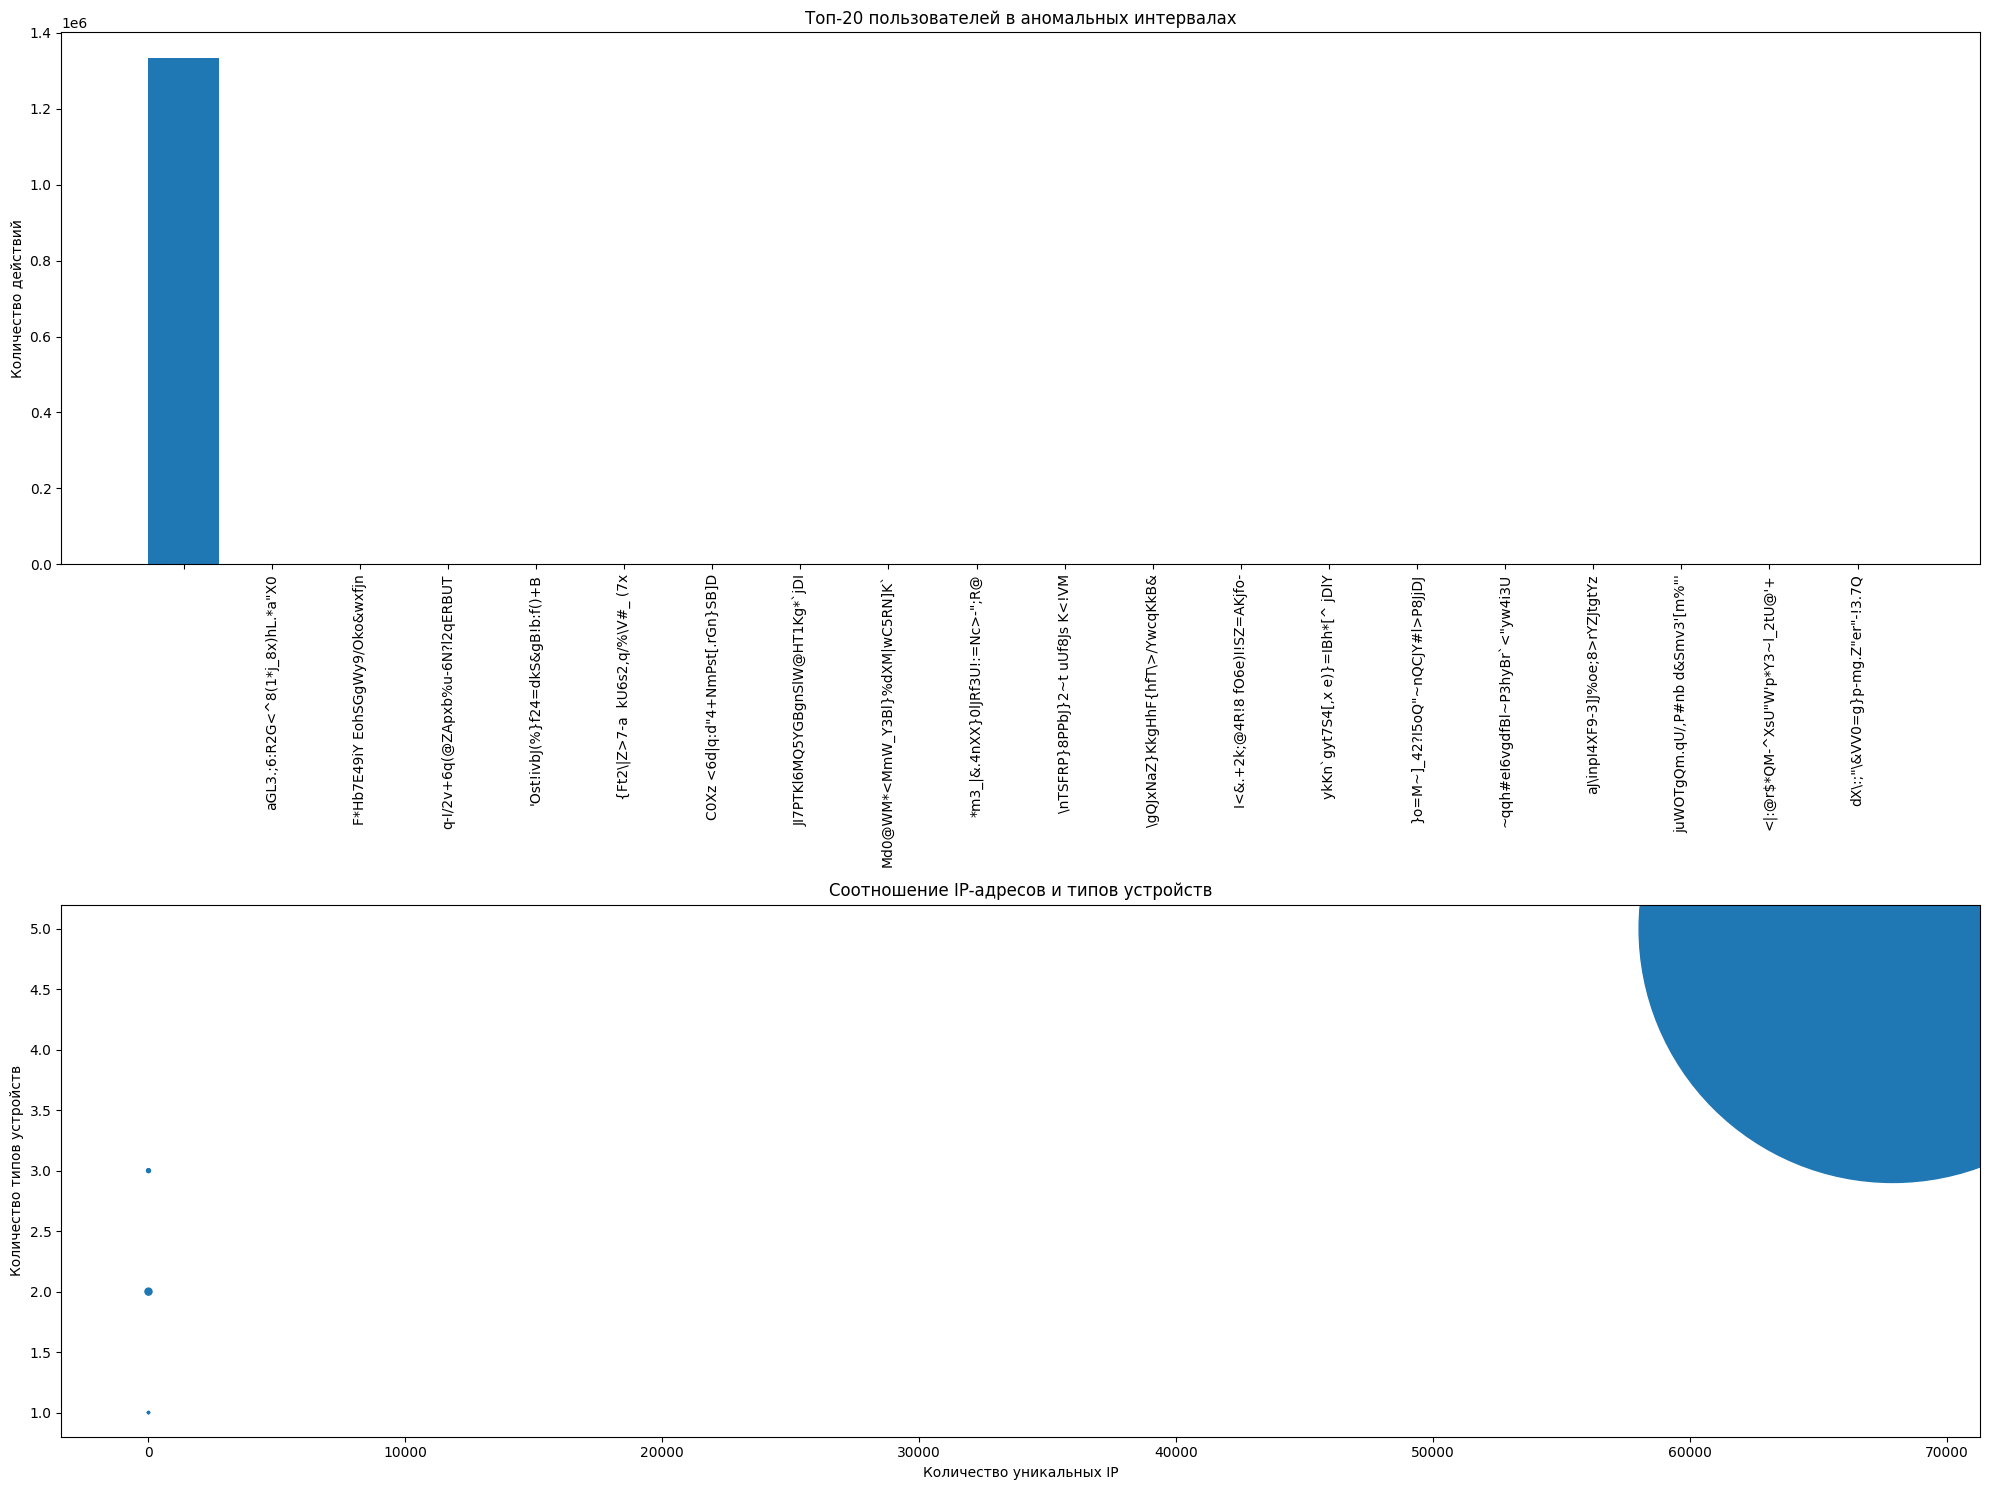

In [1]:
from google.colab import drive
import pandas as pd
import gdown
import gc
import matplotlib.pyplot as plt
import seaborn as sns
gc.collect()

file_id = '1GHIUeCjB5nks1RRHwyDY0RI0Dg73QlpG'
output = 'data.parquet'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

drive.mount('/content/drive')

try:
    data = pd.read_parquet('data.parquet', engine='pyarrow')
    print("ок")
    print(data.head())
except Exception as e:
    print("где-то беда", e)
cols = ['ts', 'randPAS_user_passport_id', 'ip', 'ua_device_type', 'event']
data = pd.read_parquet('data.parquet', columns=cols, engine='pyarrow')

# Преобразуем timestamp сразу при загрузке
data['ts'] = pd.to_datetime(data['ts'])

data['time_bin'] = data['ts'].dt.floor('5S')

# Считаем события в каждом интервале
actions_per_5s = data.groupby('time_bin').size().reset_index(name='count')

plt.figure(figsize=(15, 6))
plt.plot(actions_per_5s['time_bin'], actions_per_5s['count'])
plt.title('Количество действий пользователей за 5-секундные интервалы')
plt.xlabel('Время')
plt.ylabel('Количество действий')
plt.xticks(rotation=45)
plt.grid()
plt.show()

mean_actions = actions_per_5s['count'].mean()
std_actions = actions_per_5s['count'].std()

threshold = mean_actions + 3 * std_actions
print(f"Порог аномальной активности: {threshold:.1f} действий за 5 секунд")
anomaly_intervals = actions_per_5s[actions_per_5s['count'] > threshold]

print(f"Найдено {len(anomaly_intervals)} аномальных интервалов:")
print(anomaly_intervals)
# Создаем список аномальных временных интервалов
anomaly_times = anomaly_intervals['time_bin'].tolist()

# Фильтруем исходные данные по этим интервалам
anomaly_data = data[data['time_bin'].isin(anomaly_times)]

# Группируем по пользователям и считаем их действия
user_anomaly_activity = anomaly_data.groupby('randPAS_user_passport_id').agg(
    total_actions=('event', 'count'),
    unique_ip=('ip', 'nunique'),
    device_types=('ua_device_type', 'nunique')
).sort_values('total_actions', ascending=False)

print("\nТоп пользователей в аномальных интервалах:")
print(user_anomaly_activity.head(10))
plt.figure(figsize=(20, 15))

# График 1: Распределение действий в аномальных интервалах
plt.subplot(2, 1, 1)
plt.bar(user_anomaly_activity.index.astype(str)[:20],
        user_anomaly_activity['total_actions'][:20])
plt.title('Топ-20 пользователей в аномальных интервалах')
plt.ylabel('Количество действий')
plt.xticks(rotation=90)

# График 2: Соотношение IP и устройств
plt.subplot(2, 1, 2)
plt.scatter(user_anomaly_activity['unique_ip'],
            user_anomaly_activity['device_types'],
            s=user_anomaly_activity['total_actions']/10)
plt.title('Соотношение IP-адресов и типов устройств')
plt.xlabel('Количество уникальных IP')
plt.ylabel('Количество типов устройств')

plt.tight_layout()
plt.show()
!jupyter nbconvert --to script Untitled7.ipynb




